# SOMClassifier: Salinas Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, make_scorer, recall_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import scipy.io as sio
import pickle

# --- for running the script without pip
import sys
sys.path.append("../")
# ---

import susi

## Get data
Source for datasets: http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes

In [2]:
X_salinas = sio.loadmat("salinas/Salinas_corrected.mat")["salinas_corrected"]
y_salinas = sio.loadmat("salinas/Salinas_gt.mat")["salinas_gt"]
print(X_salinas.shape, y_salinas.shape)

(512, 217, 204) (512, 217)


In [3]:
classes_salinas = {
    1: "Brocoli green weeds 1",
    2: "Brocoli green weeds 2",
    3: "Fallow",
    4: "Fallow rough plow",
    5: "Fallow smooth",
    6: "Stubble",
    7: "Celery",
    8: "Grapes untrained",
    9: "Soil vinyard develop",
    10: "Corn senesced green weeds",
    11: "Lettuce romaine 4wk",
    12: "Lettuce romaine 5wk",
    13: "Lettuce romaine 6wk",
    14: "Lettuce romaine 7wk",
    15: "Vinyard untrained",
    16: "Vinyard vertical trellis",
}

classes_salinas_orig = {
    1: "Brocoli_green_weeds_1",
    2: "Brocoli_green_weeds_2",
    3: "Fallow",
    4: "Fallow_rough_plow",
    5: "Fallow_smooth",
    6: "Stubble",
    7: "Celery",
    8: "Grapes_untrained",
    9: "Soil_vinyard_develop",
    10: "Corn_senesced_green_weeds",
    11: "Lettuce_romaine_4wk",
    12: "Lettuce_romaine_5wk",
    13: "Lettuce_romaine_6wk",
    14: "Lettuce_romaine_7wk",
    15: "Vinyard_untrained",
    16: "Vinyard_vertical_trellis",
}

In [4]:
mask_salinas = y_salinas > 0
X_salinas_m = X_salinas[mask_salinas]
y_salinas_m = y_salinas[mask_salinas]
print(X_salinas_m.shape, y_salinas_m.shape)

(54129, 204) (54129,)


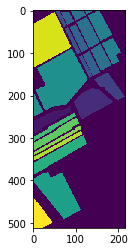

In [5]:
plt.imshow(y_salinas)

## Classify Salinas

In [6]:
scorer = {
    "oa": "accuracy",
    # "f1_micro": "f1_micro",
    # "f1_macro": "f1_macro",
    "aa": "recall_macro",
    "kappa": make_scorer(cohen_kappa_score),
}

som = susi.SOMClassifier(
    n_rows=40,
    n_columns=20,
    n_iter_unsupervised=5000,
    n_iter_supervised=20000,
    neighborhood_mode_unsupervised="linear",
    neighborhood_mode_supervised="linear",
    learn_mode_unsupervised="min",
    learn_mode_supervised="min",
    learning_rate_start=0.5,
    learning_rate_end=0.05,
    do_class_weighting=False,
    random_state=None)

cv_som = cross_validate(
    som, X_salinas_m, y_salinas_m, cv=5, n_jobs=-1,
    scoring=scorer,
    return_train_score=True, return_estimator=True, verbose=1)
pickle.dump(cv_som, open("pickles/SOMClassifier_cv.p", "wb"))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.0min finished


In [7]:
cv_som = pickle.load(open("pickles/SOMClassifier_cv.p", "rb"))

print("OA\t{0:.2f}\t{1:.2f}".format(np.mean(cv_som['train_oa'])*100, np.mean(cv_som['test_oa'])*100))
print("AA\t{0:.2f}\t{1:.2f}".format(np.mean(cv_som['train_aa'])*100, np.mean(cv_som['test_aa'])*100))
print("Kappa\t{0:.2f}\t{1:.2f}".format(np.mean(cv_som['train_kappa'])*100, np.mean(cv_som['test_kappa'])*100))

OA	12.79	12.18
AA	9.01	8.01
Kappa	3.11	2.37


In [8]:
som = cv_som["estimator"][np.argmax(cv_som['test_oa'])]
y_pred = som.predict(X_salinas_m)
pickle.dump(y_pred, open("pickles/SOMClassifier_pred.p", "wb"))

In [9]:
def plot_som_histogram(bmu_list, n_rows, n_columns, fontsize=15):
    """Plot 2D Histogram of SOM.

    Plot 2D Histogram with one bin for each SOM node. The content of one
    bin is the number of datapoints matched to the specific node.

    """
    fig, ax = plt.subplots(1, 1, figsize=(3, 6))

    # colormap
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

    #bounds = np.linspace(0, 5, 6)
    bounds = np.arange(0.,600.,100.)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ax2 = fig.add_axes([0.96, 0.12, 0.04, 0.76])
    cbar = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', extend="max")
    cbar.ax.set_ylabel('Number of datapoints', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    counts, xedges, yedges, Image = ax.hist2d(
        [x[1] for x in bmu_list], [x[0] for x in bmu_list],
        bins=[n_columns, n_rows], cmin=1, cmap=cmap, norm=norm)
    
    for label in cbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.set_xlabel("SOM columns", fontsize=fontsize)
    ax.set_ylabel("SOM rows", fontsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

    # to be compatible with plt.imshow:
    ax.invert_yaxis()

    plt.grid(b=False)
    plt.savefig("plots/class_som_histogram.pdf", bbox_inches='tight')

In [10]:
bmu_list = som.get_bmus(X_salinas_m, som.unsuper_som_)

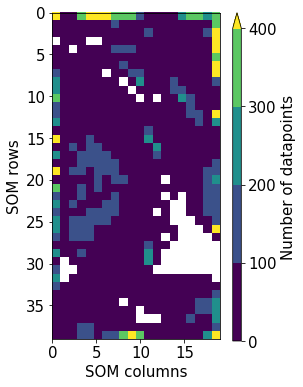

In [11]:
plot_som_histogram(bmu_list, 40, 20)

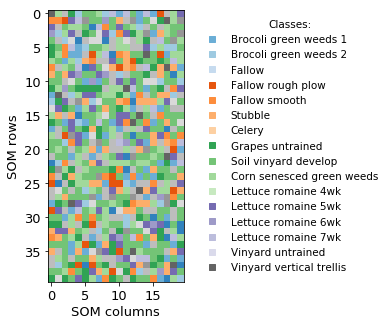

In [12]:
def plot_estimation_map(estimation_map, fontsize=13):
    plt.figure(figsize=(6,5))
    cmap = matplotlib.cm.tab20c
    cmaplist = [cmap(i) for i in range(cmap.N)]    # extract all colors
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_bad('white')
    plt.imshow(estimation_map, cmap=cmap)
    plt.xlabel("SOM columns", fontsize=fontsize)
    plt.ylabel("SOM rows", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    # legend
    for key in classes_salinas.keys():
        mycolor = cmap(key)
        plt.plot(0, 0, "s", c=mycolor, label=classes_salinas[key])
    legend = plt.legend(bbox_to_anchor=(2.5, 1.0), fontsize=fontsize*0.8, frameon=False, ncol=1, title="Classes:")
    plt.setp(legend.get_title(),fontsize=fontsize*0.8)
    
    plt.grid(b=False)
    plt.savefig("plots/class_output_distribution.pdf", bbox_inches='tight')

estimation_map = np.squeeze(som.get_estimation_map())
plot_estimation_map(estimation_map)

### Plot u-matrix

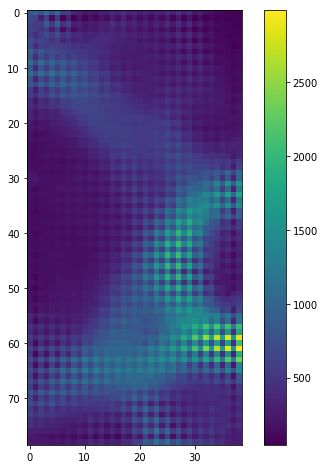

In [13]:
u_matrix = som.get_u_matrix()

plt.figure(figsize=(8,8))
plt.imshow(np.squeeze(u_matrix))
plt.colorbar()

### Plot feature variances

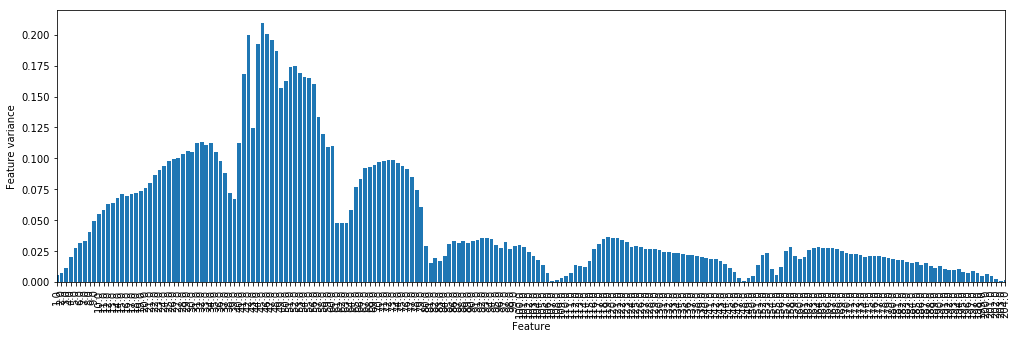

In [16]:
variances = som.variances_
x_grid = np.linspace(1, X_salinas_m.shape[1], X_salinas_m.shape[1])
plt.figure(figsize=(17,5))
plt.bar(x_grid, variances)
plt.xlabel("Feature")
plt.ylabel("Feature variance")
plt.xticks(x_grid, x_grid, rotation=90)
plt.xlim(x_grid[0], x_grid[-1])
plt.show()

## Random Forest

In [17]:
scorer = {
    "oa": "accuracy",
    "aa": "recall_macro",
    "kappa": make_scorer(cohen_kappa_score),
}

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cv_rf = cross_validate(
    rf, X_salinas_m, y_salinas_m, cv=5, n_jobs=-1,
    scoring=scorer,
    return_train_score=True, return_estimator=True, verbose=1)
pickle.dump(cv_rf, open("pickles/RFClassifier_cv.p", "wb"))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.5s finished


In [18]:
cv_rf = pickle.load(open("pickles/RFClassifier_cv.p", "rb"))

print("OA\t{0:.2f}\t{1:.2f}".format(np.mean(cv_rf['train_oa'])*100, np.mean(cv_rf['test_oa'])*100))
print("AA\t{0:.2f}\t{1:.2f}".format(np.mean(cv_rf['train_aa'])*100, np.mean(cv_rf['test_aa'])*100))
print("Kappa\t{0:.2f}\t{1:.2f}".format(np.mean(cv_rf['train_kappa'])*100, np.mean(cv_rf['test_kappa'])*100))

OA	100.00	90.00
AA	100.00	93.77
Kappa	100.00	88.85


In [19]:
rf_best = cv_rf["estimator"][np.argmax(cv_rf['test_oa'])]
y_pred_rf = rf_best.predict(X_salinas_m)
pickle.dump(y_pred_rf, open("pickles/RFClassifier_pred.p", "wb"))

In [20]:
print("All:", accuracy_score(y_salinas_m, y_pred_rf), f1_score(y_salinas_m, y_pred_rf, average="macro"),
     cohen_kappa_score(y_salinas_m, y_pred_rf)) 

All: 0.9877884313399472 0.9946664144166021 0.986399569338468


## Evaluate hyperparameter optimization

## Plot classification results

In [22]:
y_pred = pickle.load(open("pickles/SOMClassifier_pred.p", "rb"))
y_pred_rf = pickle.load(open("pickles/RFClassifier_pred.p", "rb"))

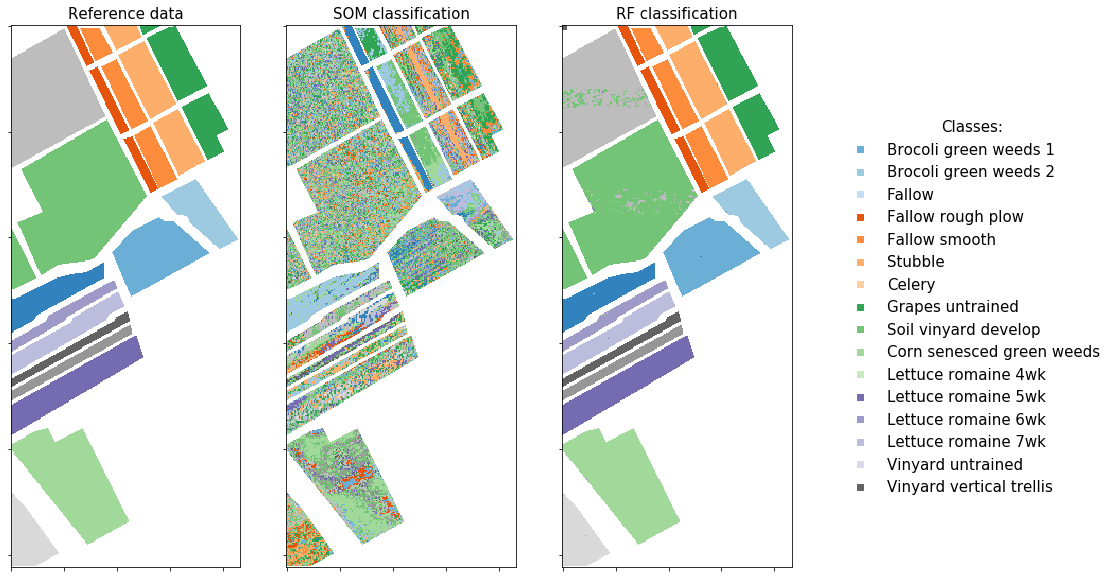

In [23]:
def plot_salinas_result(fontsize=15):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,10))

    # colormap
    cmap = matplotlib.cm.tab20c
    cmaplist = [cmap(i) for i in range(cmap.N)]    # extract all colors
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    cmap.set_bad('white')

    # plots 1: ground truth
    ax1.imshow(np.ma.masked_where(y_salinas <1, y_salinas), cmap=cmap)
    ax1.axes.get_xaxis().set_ticklabels([])
    ax1.axes.get_yaxis().set_ticklabels([])
    ax1.set_title("Reference data", fontsize=fontsize)
    
    # plots 2: SOM
    y_salinas_plot = np.copy(y_salinas)
    y_salinas_plot[mask_salinas] = y_pred
    im2 = ax2.imshow(np.ma.masked_where(y_salinas_plot <1, y_salinas_plot), cmap=cmap)
    ax2.axes.get_xaxis().set_ticklabels([])
    ax2.axes.get_yaxis().set_ticklabels([])
    ax2.set_title("SOM classification", fontsize=fontsize)
    
    # plots 3: SOM
    y_salinas_plot = np.copy(y_salinas)
    y_salinas_plot[mask_salinas] = y_pred_rf
    im3 = ax3.imshow(np.ma.masked_where(y_salinas_plot <1, y_salinas_plot), cmap=cmap)
    ax3.axes.get_xaxis().set_ticklabels([])
    ax3.axes.get_yaxis().set_ticklabels([])
    ax3.set_title("RF classification", fontsize=fontsize)
    
    # legend
    for key in classes_salinas.keys():
        mycolor = cmap(key)
        plt.plot(0, 0, "s", c=mycolor, label=classes_salinas[key])
    legend = plt.legend(bbox_to_anchor=(2.4, 0.85), fontsize=fontsize, frameon=False, title="Classes:")
    plt.setp(legend.get_title(),fontsize=fontsize)

    plt.savefig("plots/class_salinas_result.pdf", bbox_inches='tight')

plot_salinas_result()